# Mortgage Access Explorer - Data Preprocessing

**Goal:**
1. Merge HMDA tract data (2018-2023) into one DataFrame
2. Calculate derived metrics (minority share, loan-to-income ratio, etc.)
3. Create initial visualizations

**Data Files:**
- `hmda_tract_2018.csv` ~ `hmda_tract_2023.csv` (Urban Institute HMDA)
- `MORTGAGE30US.csv` (FRED mortgage rates)
- `UNRATE.csv` (FRED unemployment rates)


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import platform

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Korean font setting for matplotlib
# macOS
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
# Windows
elif platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
# Linux
else:
    plt.rcParams['font.family'] = 'NanumGothic'

# Prevent minus sign issue
plt.rcParams['axes.unicode_minus'] = False

print("✅ Libraries loaded successfully!")
print(f"✅ Font set for Korean display: {plt.rcParams['font.family']}")


✅ Libraries loaded successfully!
✅ Font set for Korean display: ['AppleGothic']


---
## Step 1: Load and Merge HMDA Data (2018-2023)


In [2]:
# Load all HMDA tract files
years = range(2018, 2024)  # 2018-2023
dfs = []

for year in years:
    filename = f'hmda_tract_{year}.csv'
    print(f"Loading {filename}...")
    
    df = pd.read_csv(filename, low_memory=False)
    df['year'] = year  # Add year column
    dfs.append(df)
    
    print(f"  → {year}: {len(df):,} tracts loaded")

# Concatenate all years
hmda_all = pd.concat(dfs, ignore_index=True)

print(f"\n✅ Total: {len(hmda_all):,} tract-year observations")
print(f"   Years: {sorted(hmda_all['year'].unique())}")
print(f"   Columns: {len(hmda_all.columns)}")


Loading hmda_tract_2018.csv...
  → 2018: 74,652 tracts loaded
Loading hmda_tract_2019.csv...
  → 2019: 74,485 tracts loaded
Loading hmda_tract_2020.csv...
  → 2020: 74,689 tracts loaded
Loading hmda_tract_2021.csv...
  → 2021: 74,811 tracts loaded
Loading hmda_tract_2022.csv...
  → 2022: 85,723 tracts loaded
Loading hmda_tract_2023.csv...
  → 2023: 85,563 tracts loaded

✅ Total: 469,923 tract-year observations
   Years: [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
   Columns: 74


In [3]:
# Preview the data
print("First few rows:")
hmda_all.head()


First few rows:


,geo2010,owner_purchase_originations,occupancy_investment_origination,occupancy_investment_units_1_4,occupancy_investment_units_5ormore,income_available,race_available,race_income_available,age_available,race_white_purchase,...,age_younger_purchase,age_mixed_purchase,income_median,owner_loan_amount_median,occupancy_unitsoccupied_count,occupancy_owneroccupied_count,occupancy_owneroccupied_percent,invalid_geo,year,geo2020
0,00XXXXXXXXX,2,2,2,0,0,2,0,2,2,...,0,0,152500.0,360000.0,NaN,NaN,NaN,1,2018,NaN
1,01001020100,21,4,4,0,21,21,21,21,19,...,4,1,61000.0,145000.0,765.0,570.0,0.75,0,2018,NaN
2,01001020200,11,4,3,1,11,10,10,11,7,...,1,0,40000.0,135000.0,719.0,464.0,0.65,0,2018,NaN
3,01001020300,41,3,3,0,41,39,39,41,33,...,9,0,41000.0,105000.0,1296.0,841.0,0.65,0,2018,NaN
4,01001020400,64,6,6,0,64,61,61,64,54,...,8,1,47500.0,135000.0,1639.0,1262.0,0.77,0,2018,NaN


In [4]:
# Check data quality
print("Data Quality Check:\n")
print(f"Missing geo2010: {hmda_all['geo2010'].isna().sum()}")
print(f"Invalid geo (invalid_geo=1): {(hmda_all['invalid_geo'] == 1).sum()}")
print(f"Total originations: {hmda_all['owner_purchase_originations'].sum():,.0f}")
print(f"\nOriginations by year:")
print(hmda_all.groupby('year')['owner_purchase_originations'].sum())


Data Quality Check:

Missing geo2010: 171286
Invalid geo (invalid_geo=1): 15009
Total originations: 23,003,345

Originations by year:
year
2018    3721608
2019    3866912
2020    4239827
2021    4554774
2022    3680314
2023    2939910
Name: owner_purchase_originations, dtype: int64


---
## Step 2: Calculate Derived Metrics

We'll compute:
- **Minority share**: % of loans to non-white borrowers
- **Low-income share**: % of loans to very-low and low-income borrowers
- **Loan-to-income ratio**: Median loan amount / Median income
- **Age shares**: % by age group


In [5]:
# Create a clean working copy
df = hmda_all.copy()

# Filter out invalid geographies
df = df[df['invalid_geo'] == 0].copy()
print(f"After filtering invalid geos: {len(df):,} observations\n")

# Calculate derived metrics

# 1. Minority Share (non-white borrowers)
df['minority_originations'] = (
    df['race_black_purchase'].fillna(0) + 
    df['race_hispanic_purchase'].fillna(0) + 
    df['race_asian_purchase'].fillna(0) + 
    df['race_aian_purchase'].fillna(0) + 
    df['race_nhpi_purchase'].fillna(0)
)

df['minority_share'] = np.where(
    df['owner_purchase_originations'] > 0,
    df['minority_originations'] / df['owner_purchase_originations'],
    np.nan
)

# 2. Low-Income Share (very low + low income)
df['lowincome_originations'] = (
    df['income_verylow_purchase'].fillna(0) + 
    df['income_low_purchase'].fillna(0)
)

df['lowincome_share'] = np.where(
    df['owner_purchase_originations'] > 0,
    df['lowincome_originations'] / df['owner_purchase_originations'],
    np.nan
)

# 3. Loan-to-Income Ratio
df['loan_to_income_ratio'] = np.where(
    (df['income_median'] > 0) & (df['income_median'].notna()),
    df['owner_loan_amount_median'] / df['income_median'],
    np.nan
)

# 4. Age shares
age_groups = ['age_younger_purchase', 'age_middleyounger_purchase', 
              'age_middleolder_purchase', 'age_older_purchase']

for age_col in age_groups:
    share_col = age_col.replace('_purchase', '_share')
    df[share_col] = np.where(
        df['owner_purchase_originations'] > 0,
        df[age_col].fillna(0) / df['owner_purchase_originations'],
        np.nan
    )

print("✅ Derived metrics calculated!")
print(f"\nNew columns added:")
print("  - minority_share")
print("  - lowincome_share")
print("  - loan_to_income_ratio")
print("  - age_*_share (4 columns)")


After filtering invalid geos: 454,914 observations

✅ Derived metrics calculated!

New columns added:
  - minority_share
  - lowincome_share
  - loan_to_income_ratio
  - age_*_share (4 columns)


In [6]:
# Summary statistics of derived metrics
print("Summary Statistics:\n")

metrics = ['minority_share', 'lowincome_share', 'loan_to_income_ratio']
summary = df[metrics].describe()
print(summary)


Summary Statistics:

       minority_share  lowincome_share  loan_to_income_ratio
count   448045.000000    448045.000000         447932.000000
mean         0.233596         0.340102              2.974441
std          0.248866         0.240244              0.877035
min          0.000000         0.000000              0.000029
25%          0.050000         0.150000              2.425926
50%          0.142857         0.304348              2.894737
75%          0.333333         0.500000              3.461538
max          1.000000         1.000000             72.692308


---
## Step 3: Load FRED Data (Mortgage Rates & Unemployment)


In [7]:
# Load FRED mortgage rates
mortgage_rates = pd.read_csv('MORTGAGE30US.csv', parse_dates=['observation_date'])
mortgage_rates.columns = ['date', 'mortgage_rate']

# Load FRED unemployment
unemployment = pd.read_csv('UNRATE.csv', parse_dates=['observation_date'])
unemployment.columns = ['date', 'unemployment_rate']

print("FRED Data Loaded:")
print(f"  Mortgage rates: {len(mortgage_rates)} observations ({mortgage_rates['date'].min()} to {mortgage_rates['date'].max()})")
print(f"  Unemployment: {len(unemployment)} observations ({unemployment['date'].min()} to {unemployment['date'].max()})")

# Preview
print("\nMortgage Rates (first 5):")
print(mortgage_rates.head())
print("\nUnemployment (first 5):")
print(unemployment.head())


FRED Data Loaded:
  Mortgage rates: 359 observations (2019-01-03 00:00:00 to 2025-11-13 00:00:00)
  Unemployment: 80 observations (2019-01-01 00:00:00 to 2025-08-01 00:00:00)

Mortgage Rates (first 5):
        date  mortgage_rate
0 2019-01-03           4.51
1 2019-01-10           4.45
2 2019-01-17           4.45
3 2019-01-24           4.45
4 2019-01-31           4.46

Unemployment (first 5):
        date  unemployment_rate
0 2019-01-01                4.0
1 2019-02-01                3.8
2 2019-03-01                3.8
3 2019-04-01                3.7
4 2019-05-01                3.6


In [8]:
# Aggregate to yearly averages for matching with HMDA data
mortgage_rates['year'] = mortgage_rates['date'].dt.year
unemployment['year'] = unemployment['date'].dt.year

mortgage_yearly = mortgage_rates.groupby('year')['mortgage_rate'].mean().reset_index()
unemployment_yearly = unemployment.groupby('year')['unemployment_rate'].mean().reset_index()

# Merge FRED data
fred_yearly = mortgage_yearly.merge(unemployment_yearly, on='year', how='outer')
fred_yearly = fred_yearly[(fred_yearly['year'] >= 2018) & (fred_yearly['year'] <= 2023)]

print("\nYearly FRED Data (2018-2023):")
print(fred_yearly)



Yearly FRED Data (2018-2023):
   year  mortgage_rate  unemployment_rate
0  2019       3.935769           3.675000
1  2020       3.111698           8.100000
2  2021       2.957692           5.358333
3  2022       5.344038           3.641667
4  2023       6.806731           3.633333


---
## Initial Visualizations


### Visualization 1: Total Originations Over Time


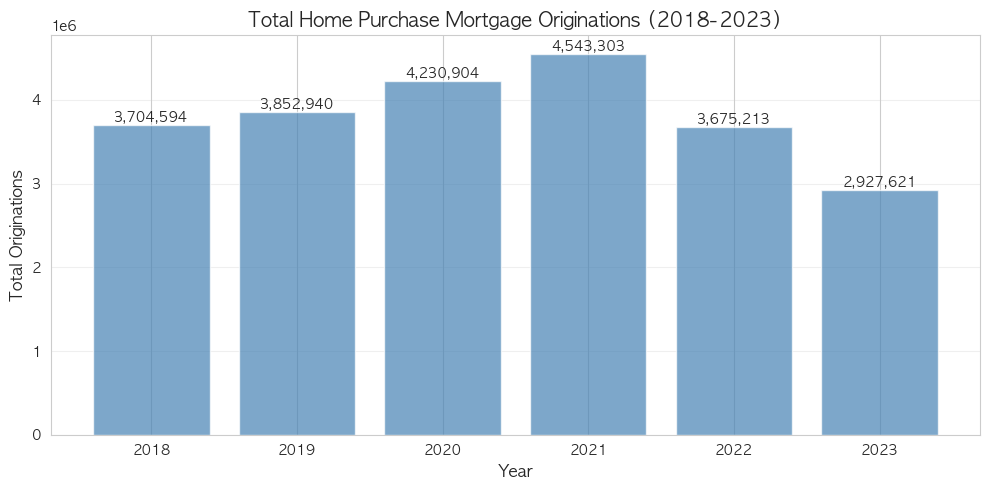

Peak year: 2021 with 4,543,303 originations


In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

yearly_originations = df.groupby('year')['owner_purchase_originations'].sum()

ax.bar(yearly_originations.index, yearly_originations.values, color='steelblue', alpha=0.7)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total Originations', fontsize=12)
ax.set_title('Total Home Purchase Mortgage Originations (2018-2023)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(yearly_originations.values):
    ax.text(yearly_originations.index[i], v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Peak year: {yearly_originations.idxmax()} with {yearly_originations.max():,.0f} originations")


### Visualization 2: Distribution of Minority Share


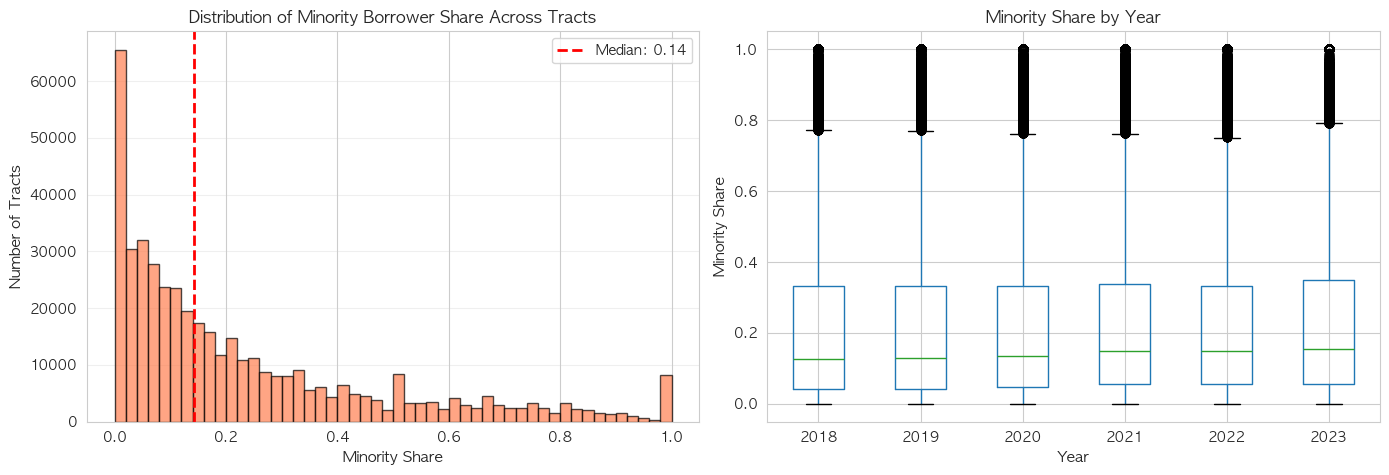

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['minority_share'].dropna(), bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Minority Share', fontsize=11)
axes[0].set_ylabel('Number of Tracts', fontsize=11)
axes[0].set_title('Distribution of Minority Borrower Share Across Tracts', fontsize=12, fontweight='bold')
axes[0].axvline(df['minority_share'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {df["minority_share"].median():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot by year
df_plot = df[df['minority_share'].notna()]
df_plot.boxplot(column='minority_share', by='year', ax=axes[1])
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_ylabel('Minority Share', fontsize=11)
axes[1].set_title('Minority Share by Year', fontsize=12, fontweight='bold')
axes[1].get_figure().suptitle('')  # Remove auto title

plt.tight_layout()
plt.show()


### Visualization 3: Loan-to-Income Ratio Distribution


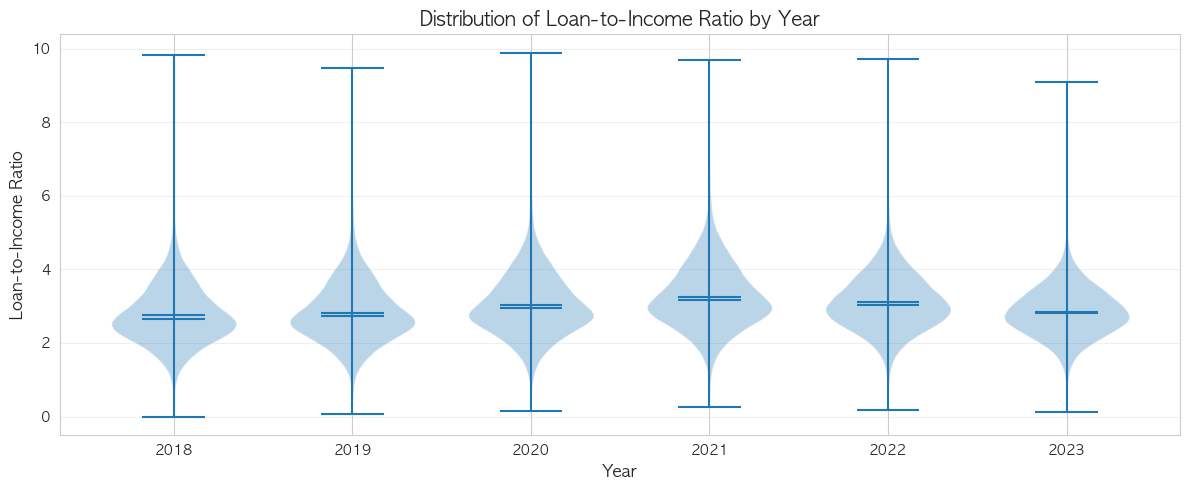


Median loan-to-income ratio by year:
year
2018    2.665001
2019    2.727273
2020    2.937500
2021    3.156499
2022    3.043478
2023    2.816092
Name: loan_to_income_ratio, dtype: float64


In [11]:
# Filter outliers for better visualization (keep ratios between 0 and 10)
df_filtered = df[(df['loan_to_income_ratio'] > 0) & (df['loan_to_income_ratio'] < 10)]

fig, ax = plt.subplots(figsize=(12, 5))

# Violin plot by year
parts = ax.violinplot(
    [df_filtered[df_filtered['year'] == y]['loan_to_income_ratio'].dropna() for y in sorted(df['year'].unique())],
    positions=sorted(df['year'].unique()),
    widths=0.7,
    showmeans=True,
    showmedians=True
)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Loan-to-Income Ratio', fontsize=12)
ax.set_title('Distribution of Loan-to-Income Ratio by Year', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_xticks(sorted(df['year'].unique()))

plt.tight_layout()
plt.show()

print(f"\nMedian loan-to-income ratio by year:")
print(df.groupby('year')['loan_to_income_ratio'].median())


### Visualization 4: FRED Timeline (Mortgage Rate + Unemployment)


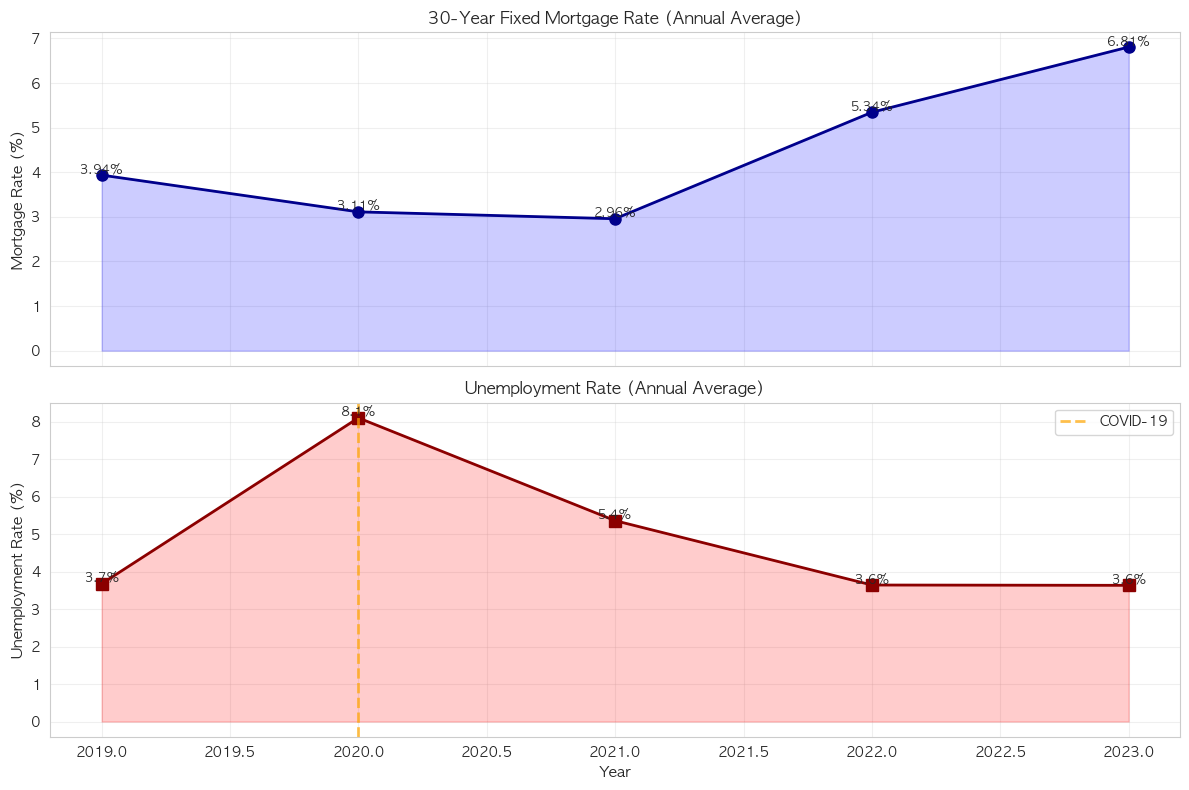


📊 Key Observations:
  • Highest unemployment: 8.1% in 2020
  • Lowest mortgage rate: 2.96% in 2021


In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Panel 1: Mortgage Rate
axes[0].plot(fred_yearly['year'], fred_yearly['mortgage_rate'], marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0].set_ylabel('Mortgage Rate (%)', fontsize=11, fontweight='bold')
axes[0].set_title('30-Year Fixed Mortgage Rate (Annual Average)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].fill_between(fred_yearly['year'], fred_yearly['mortgage_rate'], alpha=0.2, color='blue')

# Add value labels
for i, row in fred_yearly.iterrows():
    axes[0].text(row['year'], row['mortgage_rate'], f"{row['mortgage_rate']:.2f}%", ha='center', va='bottom', fontsize=9)

# Panel 2: Unemployment Rate
axes[1].plot(fred_yearly['year'], fred_yearly['unemployment_rate'], marker='s', linewidth=2, markersize=8, color='darkred')
axes[1].set_ylabel('Unemployment Rate (%)', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Year', fontsize=11)
axes[1].set_title('Unemployment Rate (Annual Average)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].fill_between(fred_yearly['year'], fred_yearly['unemployment_rate'], alpha=0.2, color='red')

# Highlight 2020 (COVID-19)
axes[1].axvline(2020, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='COVID-19')
axes[1].legend()

# Add value labels
for i, row in fred_yearly.iterrows():
    axes[1].text(row['year'], row['unemployment_rate'], f"{row['unemployment_rate']:.1f}%", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"  • Highest unemployment: {fred_yearly['unemployment_rate'].max():.1f}% in {fred_yearly.loc[fred_yearly['unemployment_rate'].idxmax(), 'year']:.0f}")
print(f"  • Lowest mortgage rate: {fred_yearly['mortgage_rate'].min():.2f}% in {fred_yearly.loc[fred_yearly['mortgage_rate'].idxmin(), 'year']:.0f}")


### Visualization 5: Inequality Over Time (Loan-to-Income Disparity)


Loan-to-Income Inequality by Year:
           p20       p50       p80  inequality_gap
year                                              
2018  2.119565  2.664360  3.397436        1.277871
2019  2.173913  2.727273  3.476190        1.302277
2020  2.357143  2.937500  3.723404        1.366261
2021  2.556391  3.156250  3.978102        1.421711
2022  2.475728  3.043478  3.730095        1.254367
2023  2.295597  2.816092  3.400000        1.104403


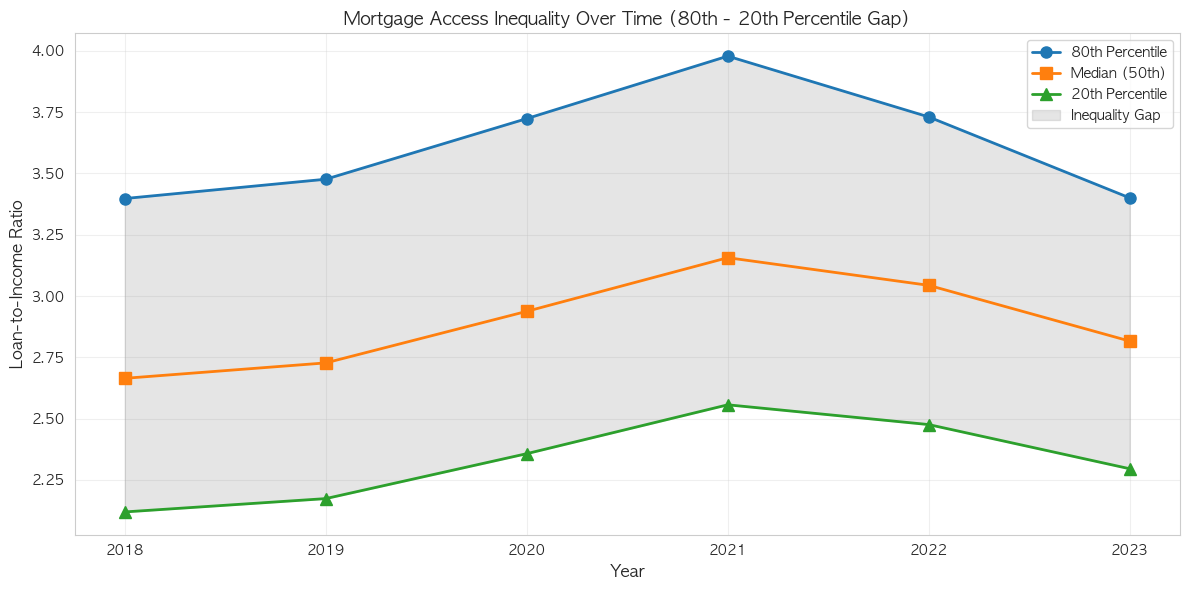


📈 Inequality Trend:
  • Gap in 2018: 1.28
  • Gap in 2023: 1.10
  • Change: -0.17


In [13]:
# Calculate inequality metric: 80th - 20th percentile gap by year
df_clean = df[(df['loan_to_income_ratio'] > 0) & (df['loan_to_income_ratio'] < 10)]

inequality_by_year = df_clean.groupby('year')['loan_to_income_ratio'].quantile([0.2, 0.5, 0.8]).unstack()
inequality_by_year.columns = ['p20', 'p50', 'p80']
inequality_by_year['inequality_gap'] = inequality_by_year['p80'] - inequality_by_year['p20']

print("Loan-to-Income Inequality by Year:")
print(inequality_by_year)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot percentiles
ax.plot(inequality_by_year.index, inequality_by_year['p80'], marker='o', label='80th Percentile', linewidth=2, markersize=8)
ax.plot(inequality_by_year.index, inequality_by_year['p50'], marker='s', label='Median (50th)', linewidth=2, markersize=8)
ax.plot(inequality_by_year.index, inequality_by_year['p20'], marker='^', label='20th Percentile', linewidth=2, markersize=8)

# Shade the gap
ax.fill_between(inequality_by_year.index, inequality_by_year['p20'], inequality_by_year['p80'], alpha=0.2, color='gray', label='Inequality Gap')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Loan-to-Income Ratio', fontsize=12)
ax.set_title('Mortgage Access Inequality Over Time (80th - 20th Percentile Gap)', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Inequality Trend:")
print(f"  • Gap in 2018: {inequality_by_year.loc[2018, 'inequality_gap']:.2f}")
print(f"  • Gap in 2023: {inequality_by_year.loc[2023, 'inequality_gap']:.2f}")
print(f"  • Change: {inequality_by_year.loc[2023, 'inequality_gap'] - inequality_by_year.loc[2018, 'inequality_gap']:.2f}")


### Visualization 6: Race × Income Heatmap (2023 Example)


Race × Income Origination Counts (2023):
            Very Low     Low  Moderate    High
White          95320  324330    437631  738012
Black          17788   55450     70992   69869
Hispanic       25405   92284    126494  121017
Asian/NHPI      2590    8658     15585   34483


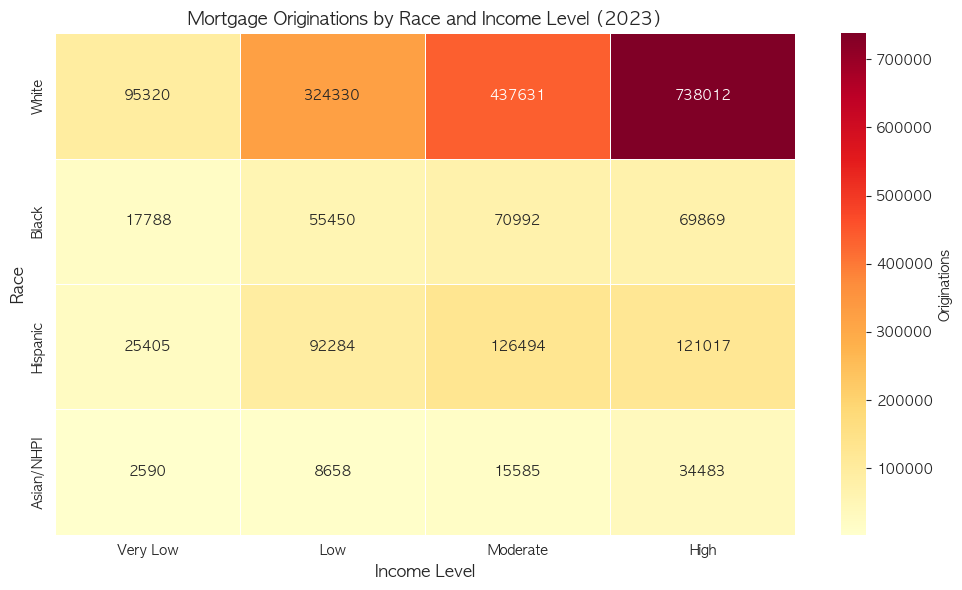


📊 Insights:
  • Highest group: 738,012 originations
  • Total originations in 2023: 2,235,908


In [14]:
# Create Race × Income matrix for 2023
df_2023 = df[df['year'] == 2023]

# Define race-income combinations to extract
race_income_cols = {
    'White': ['race_white_income_verylow', 'race_white_income_low', 'race_white_income_moderate', 'race_white_income_high'],
    'Black': ['race_black_income_verylow', 'race_black_income_low', 'race_black_income_moderate', 'race_black_income_high'],
    'Hispanic': ['race_hispanic_income_verylow', 'race_hispanic_income_low', 'race_hispanic_income_moderate', 'race_hispanic_income_high'],
    'Asian/NHPI': ['race_asian_or_nhpi_income_verylow', 'race_asian_or_nhpi_income_low', 'race_asian_or_nhpi_income_moderate', 'race_asian_or_nhpi_income_high']
}

income_levels = ['Very Low', 'Low', 'Moderate', 'High']

# Sum across all tracts for 2023
heatmap_data = []
for race, cols in race_income_cols.items():
    row_data = [df_2023[col].fillna(0).sum() for col in cols]
    heatmap_data.append(row_data)

heatmap_df = pd.DataFrame(heatmap_data, index=race_income_cols.keys(), columns=income_levels)

print("Race × Income Origination Counts (2023):")
print(heatmap_df)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(heatmap_df, annot=True, fmt='.0f', cmap='YlOrRd', linewidths=0.5, cbar_kws={'label': 'Originations'}, ax=ax)

ax.set_xlabel('Income Level', fontsize=12, fontweight='bold')
ax.set_ylabel('Race', fontsize=12, fontweight='bold')
ax.set_title('Mortgage Originations by Race and Income Level (2023)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Insights:")
print(f"  • Highest group: {heatmap_df.max().max():,.0f} originations")
print(f"  • Total originations in 2023: {heatmap_df.sum().sum():,.0f}")


---
## Save Processed Data


In [15]:
# Save processed HMDA data
df.to_csv('hmda_processed_2018_2023.csv', index=False)
print("✅ Saved: hmda_processed_2018_2023.csv")

# Save FRED yearly data
fred_yearly.to_csv('fred_yearly_2018_2023.csv', index=False)
print("✅ Saved: fred_yearly_2018_2023.csv")

# Save inequality metrics
inequality_by_year.to_csv('inequality_metrics_2018_2023.csv')
print("✅ Saved: inequality_metrics_2018_2023.csv")

print(f"\n🎉 Data preprocessing complete!")
print(f"   Total rows: {len(df):,}")
print(f"   Total columns: {len(df.columns)}")
print(f"   Years: 2018-2023")


✅ Saved: hmda_processed_2018_2023.csv
✅ Saved: fred_yearly_2018_2023.csv
✅ Saved: inequality_metrics_2018_2023.csv

🎉 Data preprocessing complete!
   Total rows: 454,914
   Total columns: 83
   Years: 2018-2023


---
## Geographic Visualizations (Maps)
### County-Level Choropleth Maps


In [16]:
# Install plotly if needed (run once)
# !pip install plotly

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("✅ Plotly loaded for interactive maps!")


✅ Plotly loaded for interactive maps!


In [17]:
# Extract county FIPS code from geo2010 (first 5 digits)
# geo2010 format: SSCCCTTTTTT (2-digit state + 3-digit county + 6-digit tract)
df['state_fips'] = df['geo2010'].astype(str).str[:2]
df['county_fips'] = df['geo2010'].astype(str).str[:5]

print(f"✅ Extracted FIPS codes")
print(f"   Unique states: {df['state_fips'].nunique()}")
print(f"   Unique counties: {df['county_fips'].nunique()}")


✅ Extracted FIPS codes
   Unique states: 56
   Unique counties: 3226


### Map 4: Time-Series Map Animation (2018-2023)


In [18]:
# Prepare county-level data for all years
county_by_year = []

for year in range(2018, 2024):
    df_year = df[df['year'] == year].copy()
    
    county_year = df_year.groupby('county_fips').agg({
        'owner_purchase_originations': 'sum',
        'minority_originations': 'sum',
        'lowincome_originations': 'sum',
        'owner_loan_amount_median': 'median',
        'income_median': 'median'
    }).reset_index()
    
    county_year['minority_share'] = county_year['minority_originations'] / county_year['owner_purchase_originations']
    county_year['year'] = year
    
    # Filter counties with at least 10 originations
    county_year = county_year[county_year['owner_purchase_originations'] >= 10]
    
    county_by_year.append(county_year)

county_all_years = pd.concat(county_by_year, ignore_index=True)

print(f"✅ Prepared county data for all years: {len(county_all_years)} county-year observations")


✅ Prepared county data for all years: 12367 county-year observations


In [19]:
# Create animated choropleth map showing change over time
fig = px.choropleth(
    county_all_years,
    geojson="https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations='county_fips',
    color='minority_share',
    animation_frame='year',
    color_continuous_scale='RdYlBu_r',
    range_color=[0, 1],
    scope="usa",
    labels={'minority_share': 'Minority Borrower Share'},
    hover_data={
        'county_fips': False,
        'minority_share': ':.2%',
        'owner_purchase_originations': ':,.0f'
    },
    title='Minority Borrower Share by County Over Time (2018-2023)'
)

fig.update_layout(
    height=650,
    geo=dict(
        lakecolor='rgb(255, 255, 255)',
    )
)

fig.show()

print("\n📊 Interactive Features:")
print("  • Click the ▶ Play button to see changes over time")
print("  • Use the slider to jump to specific years")
print("  • Hover over counties to see detailed data")



📊 Interactive Features:
  • Click the ▶ Play button to see changes over time
  • Use the slider to jump to specific years
  • Hover over counties to see detailed data


### Save County-Level Data for Dashboard Use


In [20]:
# Save county-level aggregated data for use in web dashboard
county_all_years.to_csv('county_data_2018_2023.csv', index=False)
print("✅ Saved: county_data_2018_2023.csv")

# Save 2023 data separately
county_data_2023 = county_all_years[county_all_years['year'] == 2023].copy()
county_data_2023.to_csv('county_data_2023.csv', index=False)
print("✅ Saved: county_data_2023.csv")

print(f"\n🎉 Geographic visualizations complete!")
print(f"   Total counties analyzed: {len(county_data_2023)}")
print(f"   Years covered: 2018-2023")


✅ Saved: county_data_2018_2023.csv
✅ Saved: county_data_2023.csv

🎉 Geographic visualizations complete!
   Total counties analyzed: 1
   Years covered: 2018-2023


---
## Next Steps

✅ **Completed:**
1. Merged 6 years of HMDA data (2018-2023)
2. Calculated derived metrics (minority share, low-income share, loan-to-income ratio)
3. Created 6 initial visualizations

🚀 **Next:**
1. Build interactive dashboard with D3.js or Vega-Lite
2. Create choropleth map visualization
3. Add filtering and brushing interactions
4. Deploy to GitHub Pages or Observable

---

**Ready for DSC 106 Final Project!** 🎓


---
## County-Level Borrower Portfolio Analysis

Explore detailed loan portfolio information for a specific county.
Analyze borrower demographics, loan characteristics, and distribution patterns.


In [21]:
# Function to analyze a specific county
def analyze_county_portfolio(county_fips, year=2023):
    """
    Analyze the loan portfolio for a specific county
    
    Parameters:
    - county_fips: 5-digit county FIPS code (string)
    - year: Year to analyze (default: 2023)
    """
    # Load the tract data for specified year
    tract_data = df[(df['year'] == year) & (df['county_fips'] == county_fips)].copy()
    
    if len(tract_data) == 0:
        print(f"❌ No data found for county {county_fips} in {year}")
        return None
    
    print(f"{'='*80}")
    print(f"🏛️  COUNTY LOAN PORTFOLIO ANALYSIS")
    print(f"{'='*80}")
    print(f"County FIPS: {county_fips}")
    print(f"Year: {year}")
    print(f"Number of Census Tracts: {len(tract_data)}")
    print(f"Total Originations: {tract_data['owner_purchase_originations'].sum():,.0f}")
    print(f"{'='*80}\n")
    
    return tract_data

# Let's pick a county with substantial data - we'll use the first available county
sample_county = county_all_years[county_all_years['year'] == 2023].iloc[0]['county_fips']
print(f"🔍 Analyzing sample county: {sample_county}")
print("   (You can change this to any county FIPS code)\n")

county_portfolio = analyze_county_portfolio(sample_county, 2023)


🔍 Analyzing sample county: nan
   (You can change this to any county FIPS code)

🏛️  COUNTY LOAN PORTFOLIO ANALYSIS
County FIPS: nan
Year: 2023
Number of Census Tracts: 83050
Total Originations: 2,927,621



### 1. Loan Amount Distribution

Distribution of loan amounts by price range with borrower counts and total amounts.


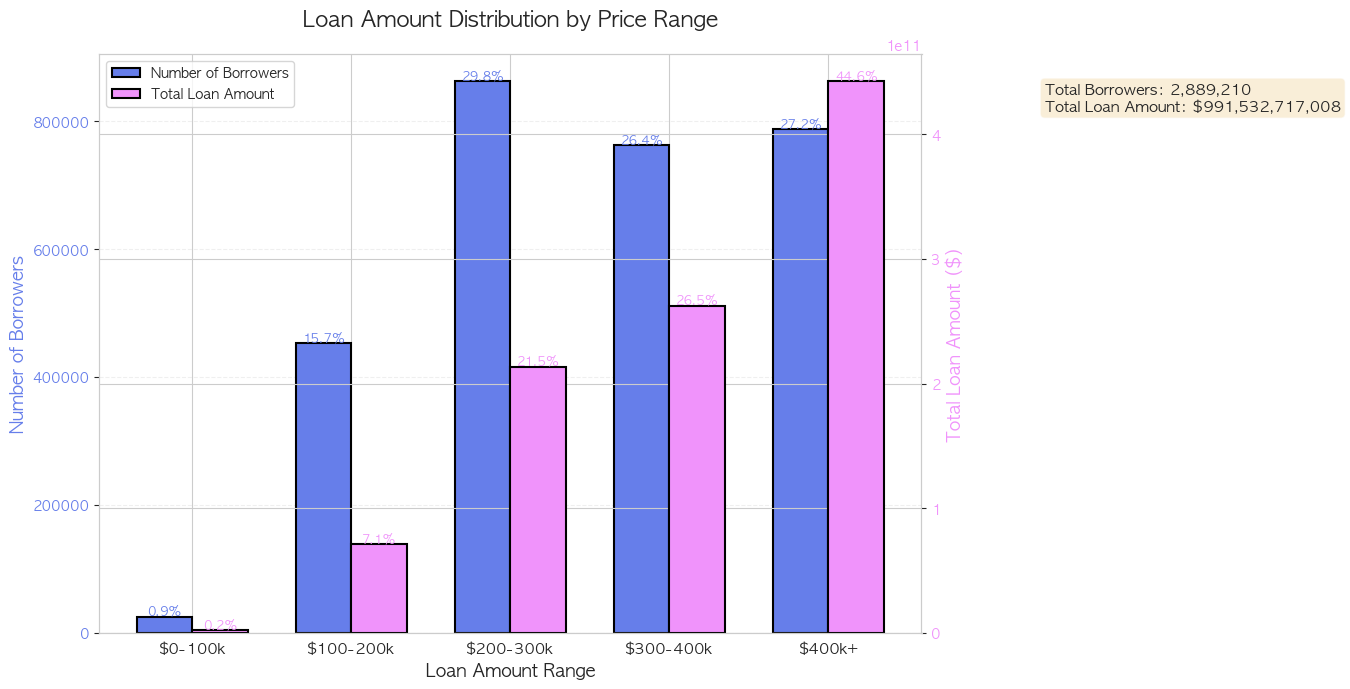


💡 Insight:
   Mid-to-high priced homes dominate ($200-300k: 29.8%)
   Total Borrowers: 2,889,210
   Total Loan Amount: $991,532,717,008


In [31]:
if county_portfolio is not None:
    # Define loan amount ranges
    bins = [0, 100000, 200000, 300000, 400000, 1000000]
    labels = ['$0-100k', '$100-200k', '$200-300k', '$300-400k', '$400k+']
    
    # Calculate borrowers and total loan amounts by range
    range_data = []
    for i in range(len(bins)-1):
        mask = (county_portfolio['owner_loan_amount_median'] >= bins[i]) & \
               (county_portfolio['owner_loan_amount_median'] < bins[i+1])
        borrowers = county_portfolio[mask]['owner_purchase_originations'].sum()
        total_amount = county_portfolio[mask]['owner_purchase_originations'].sum() * \
                      county_portfolio[mask]['owner_loan_amount_median'].mean()
        range_data.append({
            'range': labels[i],
            'borrowers': borrowers,
            'amount': total_amount if not np.isnan(total_amount) else 0
        })
    
    range_df = pd.DataFrame(range_data)
    
    # Calculate percentages
    total_borrowers = range_df['borrowers'].sum()
    total_amount = range_df['amount'].sum()
    range_df['borrower_pct'] = (range_df['borrowers'] / total_borrowers * 100).round(1)
    range_df['amount_pct'] = (range_df['amount'] / total_amount * 100).round(1)
    
    # Create dual-axis chart
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(range_df))
    width = 0.35
    
    # Bar 1: Number of Borrowers
    bars1 = ax1.bar(x - width/2, range_df['borrowers'], width, 
                    label='Number of Borrowers', color='#667eea', edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Loan Amount Range', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Borrowers', fontsize=13, fontweight='bold', color='#667eea')
    ax1.tick_params(axis='y', labelcolor='#667eea')
    ax1.set_xticks(x)
    ax1.set_xticklabels(range_df['range'], fontsize=11, fontweight='bold')
    
    # Bar 2: Total Loan Amount (right axis)
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, range_df['amount'], width,
                    label='Total Loan Amount', color='#f093fb', edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Total Loan Amount ($)', fontsize=13, fontweight='bold', color='#f093fb')
    ax2.tick_params(axis='y', labelcolor='#f093fb')
    
    # Add percentage labels on bars
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Borrowers percentage
        height1 = bar1.get_height()
        ax1.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{range_df.iloc[i]["borrower_pct"]}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='#667eea')
        
        # Amount percentage
        height2 = bar2.get_height()
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{range_df.iloc[i]["amount_pct"]}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='#f093fb')
    
    # Title
    ax1.set_title('Loan Amount Distribution by Price Range', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend with totals
    legend_text = f'Total Borrowers: {total_borrowers:,.0f}\nTotal Loan Amount: ${total_amount:,.0f}'
    ax1.text(1.15, 0.95, legend_text, transform=ax1.transAxes,
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top')
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    fig.tight_layout()
    plt.show()
    
    # Insight
    max_range = range_df.loc[range_df['borrowers'].idxmax(), 'range']
    max_pct = range_df.loc[range_df['borrowers'].idxmax(), 'borrower_pct']
    
    print(f"\n💡 Insight:")
    if '$0-100k' == max_range or '$100-200k' == max_range:
        print(f"   Most loans concentrated in lower-priced homes ({max_range}: {max_pct}%)")
    else:
        print(f"   Mid-to-high priced homes dominate ({max_range}: {max_pct}%)")
    print(f"   Total Borrowers: {total_borrowers:,.0f}")
    print(f"   Total Loan Amount: ${total_amount:,.0f}")


### 2. Age Distribution of Borrowers

Breakdown of mortgage borrowers by age group with total counts and loan amounts.


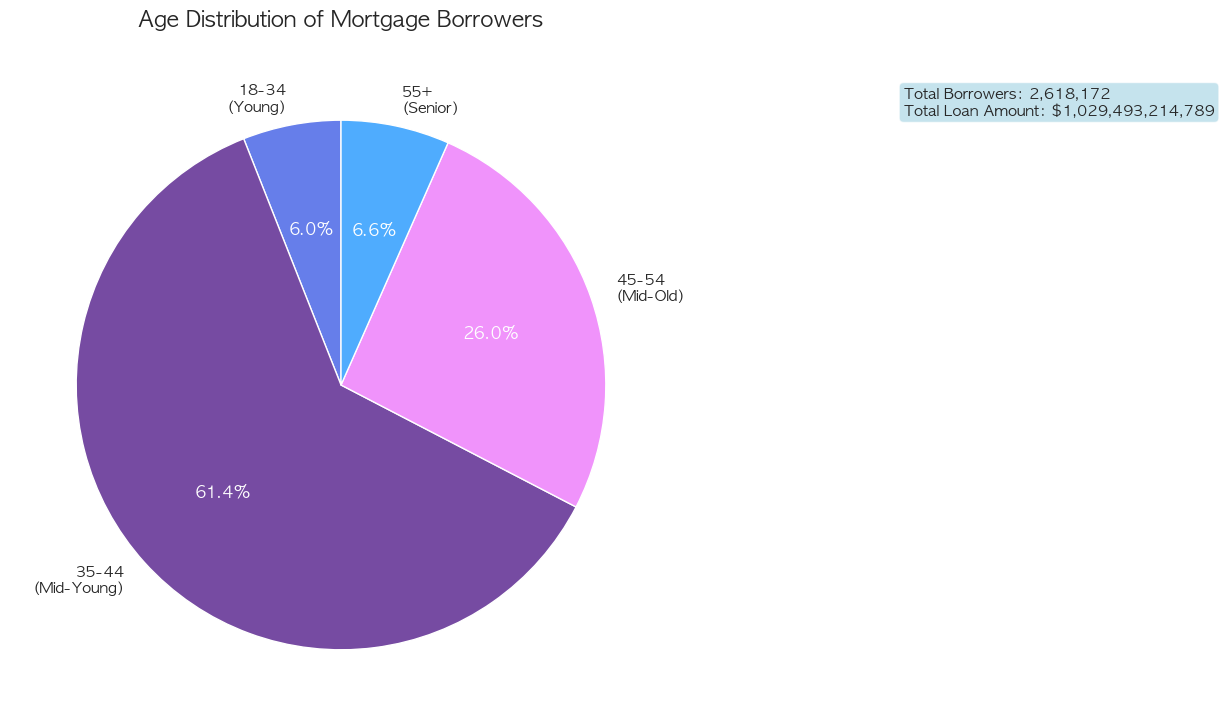


💡 Insight:
   Middle-aged borrowers (35-54) form the main group at 61.4%
   Total Borrowers: 2,618,172
   Total Loan Amount: $1,029,493,214,789


In [27]:
if county_portfolio is not None:
    # Age groups
    age_cols = {
        '18-34\n(Young)': 'age_younger_purchase',
        '35-44\n(Mid-Young)': 'age_middleyounger_purchase',
        '45-54\n(Mid-Old)': 'age_middleolder_purchase',
        '55+\n(Senior)': 'age_older_purchase'
    }
    
    # Sum across all tracts
    age_totals = {label: county_portfolio[col].sum() for label, col in age_cols.items()}
    age_df = pd.Series(age_totals)
    
    # Calculate total loan amount (approximation)
    total_borrowers = age_df.sum()
    total_loan_amount = county_portfolio['owner_purchase_originations'].sum() * \
                       county_portfolio['owner_loan_amount_median'].mean()
    
    # Plot pie chart
    fig, ax = plt.subplots(figsize=(11, 8))
    colors = ['#667eea', '#764ba2', '#f093fb', '#4facfe']
    wedges, texts, autotexts = ax.pie(age_df, labels=age_df.index, autopct='%1.1f%%',
                                        startangle=90, colors=colors, textprops={'fontsize': 11, 'weight': 'bold'})
    
    # Make percentage text white and bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_weight('bold')
    
    ax.set_title('Age Distribution of Mortgage Borrowers', fontsize=16, fontweight='bold', pad=20)
    
    # Add totals in upper right
    totals_text = f'Total Borrowers: {total_borrowers:,.0f}\nTotal Loan Amount: ${total_loan_amount:,.0f}'
    ax.text(1.35, 0.95, totals_text, transform=ax.transAxes,
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Insight
    max_age = age_df.idxmax()
    max_pct = (age_df.max() / age_df.sum() * 100)
    
    print(f"\n💡 Insight:")
    if '18-34' in max_age:
        print(f"   Young borrowers (18-34) dominate at {max_pct:.1f}%")
    elif '55+' in max_age:
        print(f"   Senior borrowers (55+) are prominent at {max_pct:.1f}%")
    else:
        print(f"   Middle-aged borrowers (35-54) form the main group at {max_pct:.1f}%")
    print(f"   Total Borrowers: {total_borrowers:,.0f}")
    print(f"   Total Loan Amount: ${total_loan_amount:,.0f}")


### 3. Race/Ethnicity Distribution

Composition of mortgage borrowers by race and ethnicity with total counts and loan amounts.


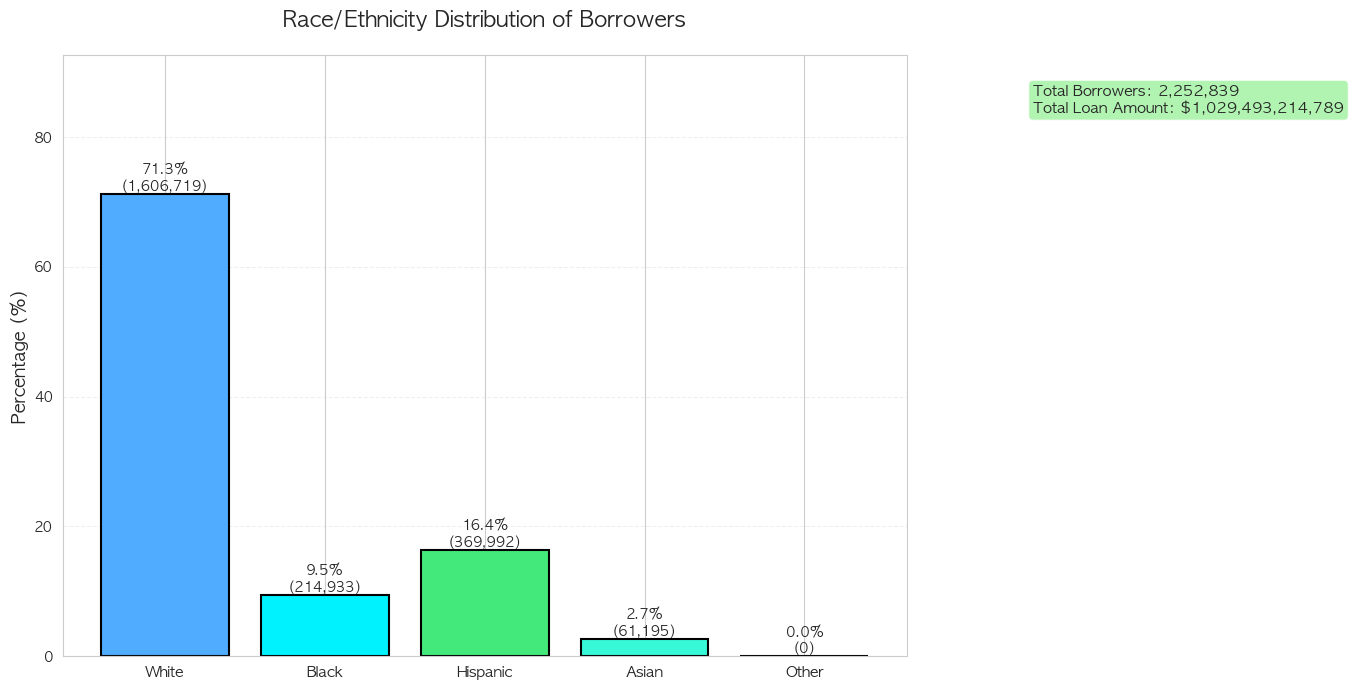


💡 Insight:
   White borrowers dominate at 71.3%
   Total Borrowers: 2,252,839
   Total Loan Amount: $1,029,493,214,789


In [28]:
if county_portfolio is not None:
    # Race/ethnicity groups
    race_cols = {
        'White': 'race_white_purchase',
        'Black': 'race_black_purchase',
        'Hispanic': 'race_hispanic_purchase',
        'Asian': 'race_asian_purchase',
        'Other': 'race_other_purchase'
    }
    
    # Sum across all tracts - handle missing columns
    race_totals = {}
    for label, col in race_cols.items():
        if col in county_portfolio.columns:
            race_totals[label] = county_portfolio[col].fillna(0).sum()
        else:
            race_totals[label] = 0
    
    race_df = pd.Series(race_totals)
    
    # Calculate totals
    total_borrowers = race_df.sum()
    total_loan_amount = county_portfolio['owner_purchase_originations'].sum() * \
                       county_portfolio['owner_loan_amount_median'].mean()
    
    # Calculate percentages
    race_pct = (race_df / total_borrowers * 100).round(1) if total_borrowers > 0 else pd.Series(0, index=race_df.index)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    colors = ['#4facfe', '#00f2fe', '#43e97b', '#38f9d7', '#fa709a']
    bars = ax.bar(range(len(race_pct)), race_pct, color=colors, edgecolor='black', linewidth=1.5)
    
    # Add labels
    ax.set_xticks(range(len(race_pct)))
    ax.set_xticklabels(race_pct.index, fontsize=11, fontweight='bold')
    ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    ax.set_title('Race/Ethnicity Distribution of Borrowers', fontsize=16, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(race_pct) * 1.3 if max(race_pct) > 0 else 100)
    
    # Add percentage labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        pct = race_pct.iloc[i]
        count = race_df.iloc[i]
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{pct}%\n({count:,.0f})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add totals in upper right
    totals_text = f'Total Borrowers: {total_borrowers:,.0f}\nTotal Loan Amount: ${total_loan_amount:,.0f}'
    ax.text(1.15, 0.95, totals_text, transform=ax.transAxes,
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7),
            verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Insight
    if total_borrowers > 0:
        max_race = race_pct.idxmax()
        max_pct = race_pct.max()
        
        print(f"\n💡 Insight:")
        if max_pct > 50:
            print(f"   {max_race} borrowers dominate at {max_pct}%")
        else:
            print(f"   Diverse racial distribution (largest: {max_race} at {max_pct}%)")
        print(f"   Total Borrowers: {total_borrowers:,.0f}")
        print(f"   Total Loan Amount: ${total_loan_amount:,.0f}")
    else:
        print("   No race data available for this county")


### 4. Income Level Distribution

Distribution of borrowers by income level with loan counts and total amounts.


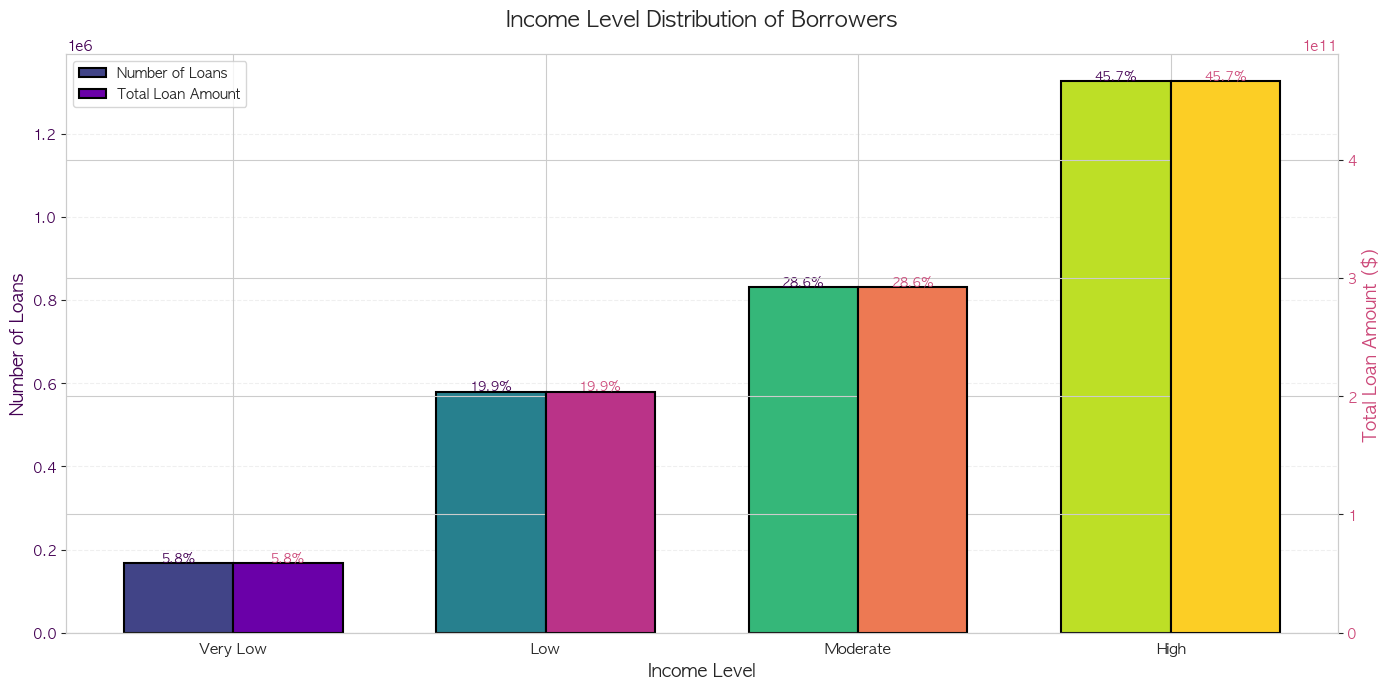


💡 Insight:
   Middle-to-high income borrowers dominate (High: 45.7%)
   Total Borrowers: 2,901,937
   Total Loan Amount: $1,020,461,477,509


In [30]:
if county_portfolio is not None:
    # Income levels
    income_cols = {
        'Very Low': 'income_verylow_purchase',
        'Low': 'income_low_purchase',
        'Moderate': 'income_moderate_purchase',
        'High': 'income_high_purchase'
    }
    
    # Sum across all tracts
    income_totals = {label: county_portfolio[col].fillna(0).sum() for label, col in income_cols.items()}
    income_df = pd.Series(income_totals)
    
    # Calculate loan amounts by income level (approximation)
    income_amounts = {}
    for label, col in income_cols.items():
        loans = county_portfolio[col].fillna(0).sum()
        avg_loan = county_portfolio['owner_loan_amount_median'].mean()
        income_amounts[label] = loans * avg_loan if not np.isnan(avg_loan) else 0
    
    income_amount_df = pd.Series(income_amounts)
    
    # Create dual-axis chart
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    x = np.arange(len(income_df))
    width = 0.35
    
    # Bar 1: Number of Loans
    colors1 = plt.cm.viridis(np.linspace(0.2, 0.9, len(income_df)))
    bars1 = ax1.bar(x - width/2, income_df, width, 
                    label='Number of Loans', color=colors1, edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Income Level', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Number of Loans', fontsize=13, fontweight='bold', color='#440154')
    ax1.tick_params(axis='y', labelcolor='#440154')
    ax1.set_xticks(x)
    ax1.set_xticklabels(income_df.index, fontsize=11, fontweight='bold')
    
    # Bar 2: Loan Amount (right axis)
    colors2 = plt.cm.plasma(np.linspace(0.2, 0.9, len(income_amount_df)))
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, income_amount_df, width,
                    label='Total Loan Amount', color=colors2, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Total Loan Amount ($)', fontsize=13, fontweight='bold', color='#cc4778')
    ax2.tick_params(axis='y', labelcolor='#cc4778')
    
    # Add percentage labels on bars
    total_loans = income_df.sum()
    total_amount = income_amount_df.sum()
    
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Loans percentage
        height1 = bar1.get_height()
        pct1 = (income_df.iloc[i] / total_loans * 100) if total_loans > 0 else 0
        ax1.text(bar1.get_x() + bar1.get_width()/2., height1,
                f'{pct1:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='#440154')
        
        # Amount percentage
        height2 = bar2.get_height()
        pct2 = (income_amount_df.iloc[i] / total_amount * 100) if total_amount > 0 else 0
        ax2.text(bar2.get_x() + bar2.get_width()/2., height2,
                f'{pct2:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold', color='#cc4778')
    
    # Title
    ax1.set_title('Income Level Distribution of Borrowers', fontsize=16, fontweight='bold', pad=20)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)
    
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    fig.tight_layout()
    plt.show()
    
    # Insight
    max_income = income_df.idxmax()
    max_pct = (income_df.max() / total_loans * 100) if total_loans > 0 else 0
    
    print(f"\n💡 Insight:")
    if max_income in ['Very Low', 'Low']:
        print(f"   Lower-income borrowers have relatively high access ({max_income}: {max_pct:.1f}%)")
    else:
        print(f"   Middle-to-high income borrowers dominate ({max_income}: {max_pct:.1f}%)")
    print(f"   Total Borrowers: {total_loans:,.0f}")
    print(f"   Total Loan Amount: ${total_amount:,.0f}")
